Sentiment analysis of movie (IMDB) reviews using dataset provided by the ACL 2011 paper, 
see http://ai.stanford.edu/~amaas/data/sentiment/
This notebook uses neural net models

The plan is to compare a variety of hyperparameters, vectorization techniques, neural net based models:
* dense neural network with bag of words
* dense neural network with fixed size input and words mapped to integers
* LSTM
* CNN


### Table of Contents<a class="anchor" id="table"></a>
* [Load data](#load)
* [Train different architectures](#train)
    * [Train NN 50 - 10 - 1](#train1)
    * [Train NN 256 - 128 - 1](#train2)
    * [Train NN with K-Fold cross validation](#kfold)
    * [Train RNN](#rnn)
* [Optimize](#opti)
    * [Optimize on dropouts](#opti_d)
        * no dropout
        * low dropout on 1 layer
        * high dropout on 1 layer
        * low dropout on 2 layers
        * high dropout on 2 layers
        * [Observation](#opti_d_o)

In [121]:
!pip install wget

In [122]:
import numpy as np
import os
import os.path
import glob
import time
import string

import pandas as pd
import matplotlib as plt

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import nltk
nltk.download('punkt')
nltk.download('stopwords')

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers
from tensorflow.keras import models

from sklearn.model_selection import train_test_split

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [0]:
from sklearn.model_selection import KFold

In [124]:
import wget
import tarfile

# By checking if the directory exists first, we allow people to delete the tarfile without the notebook re-downloading it
if os.path.isdir('aclImdb'):
    print("Dataset directory exists, taking no action")
else:    
    if not os.path.isfile('aclImdb_v1.tar.gz'):
        print("Downloading dataset")
        #!wget http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
        wget.download('http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz')
    else:
        print("Dataset already downloaded")
    
    print("Unpacking dataset")
    #!tar -xf aclImdb_v1.tar.gz 
    tar = tarfile.open("aclImdb_v1.tar.gz")
    tar.extractall()
    tar.close()
    print("Dataset unpacked in aclImdb")

Dataset directory exists, taking no action


In [0]:
def foundGPU():
  device_name = tf.test.gpu_device_name()
  if device_name != '/device:GPU:0':
    print('No GPU found')
    return False
  else: 
    print('Found GPU at: {}'.format(device_name))
    return True

In [126]:
# configuration
if foundGPU():
  SAMPLE_SIZE=12500
else:
  SAMPLE_SIZE=2000

BATCH_SIZE=64
TRAIN_TEST_RATIO=0.25
TRAINING_SET_SIZE=int(SAMPLE_SIZE * (1 - TRAIN_TEST_RATIO))
VALIDATION_SET_SIZE=int(SAMPLE_SIZE * TRAIN_TEST_RATIO)

Found GPU at: /device:GPU:0


<a href='#table'>Back</a>
# Load data<a class="anchor" id="load"></a>

## Create a dense vector from reviews 

In [0]:
time_beginning_of_notebook = time.time()
SLICE = int(SAMPLE_SIZE / 2)
positive_file_list = glob.glob(os.path.join('aclImdb/train/pos', "*.txt"))
positive_sample_file_list = positive_file_list[:SLICE]

negative_file_list = glob.glob(os.path.join('aclImdb/train/neg', "*.txt"))
negative_sample_file_list = negative_file_list[:SLICE]

import re

# load doc into memory
# regex to clean markup elements 
def load_doc(filename):
    # open the file as read only
    file = open(filename, 'r', encoding='utf8')
    # read all text
    text = re.sub('<[^>]*>', ' ', file.read())
    #text = file.read()
    # close the file
    file.close()
    return text

In [0]:
positive_strings = [load_doc(x) for x in positive_sample_file_list]
negative_strings = [load_doc(x) for x in negative_sample_file_list]

positive_tokenized = [word_tokenize(s) for s in positive_strings]
negative_tokenized = [word_tokenize(s) for s in negative_strings]

In [129]:
print(negative_tokenized[:100])

[['A', 'fabulous', 'book', 'about', 'a', 'fox', 'and', 'his', 'family', 'who', 'does', 'what', 'foxs', 'do', '.', 'that', 'being', 'stealing', 'from', 'farms', 'and', 'killing', 'prey', '.', 'until', 'a', 'trio', 'of', 'farmers', 'decide', 'they', "'ve", 'had', 'enough', 'of', 'this', 'fox', 'and', 'try', 'in', 'various', 'ways', 'to', 'have', 'the', 'problem', '``', 'solved', "''", '.', 'They', 'are', 'of', 'course', '``', 'out', 'foxed', "''", 'at', 'every', 'turn', 'and', 'while', 'the', 'trio', 'are', 'camped', 'out', 'at', 'the', 'fox', 'hole', 'the', 'family', 'perform', 'raids', 'against', 'the', 'three', 'farmers', 'land', '.', 'The', "''", 'film', "''", 'version', ',', 'and', 'I', 'use', 'the', 'term', 'film', 'very', 'loosely', ',', 'is', 'more', 'of', 'a', 'god', 'awful', 'pastiche', 'of', 'American', 'heist', 'movies', 'particularly', 'the', 'Oceans', 'movies', '.', 'They', 'they', 'even', 'have', 'George', 'clooney', 'as', 'Mr', 'fox', 'to', 'to', 'add', 'to', 'the', 'insu

In [0]:
from collections import Counter
import numpy as np

In [0]:
stop = stopwords.words('english') + list(string.punctuation) + ["''", '``', '...', "'s", "n't"]

total_counts = Counter()
all_reviews = positive_tokenized + negative_tokenized
for r in all_reviews:
    sig_words = [w.lower() for w in r if w.lower() not in stop]
    for word in sig_words:
        total_counts[word] += 1

In [0]:
VOCAB_SIZE = 1000

vocab = total_counts.most_common(VOCAB_SIZE)
vocab = [t[0] for t in vocab]


In [133]:
print(vocab)

['movie', 'film', 'one', 'like', 'good', 'would', 'even', 'time', 'story', 'really', 'see', 'much', 'well', 'could', 'get', 'bad', 'people', 'also', 'great', 'first', 'made', 'way', 'make', 'movies', 'think', 'character', 'watch', 'characters', 'many', 'two', 'films', 'seen', 'never', 'little', 'plot', 'best', 'acting', 'show', 'love', 'life', 'know', 'ever', 'still', 'man', 'better', 'end', 'say', 'scene', 'scenes', 'go', "'ve", 'something', 'back', '--', "'m", 'real', 'watching', 'thing', 'another', 'years', 'though', 'funny', 'actors', 'work', 'actually', 'nothing', 'makes', 'find', 'new', 'director', 'look', 'going', 'old', 'lot', 'every', 'part', "'re", 'us', 'things', 'world', 'cast', 'quite', 'ca', 'want', 'pretty', 'fact', 'got', 'seems', 'however', 'around', 'young', 'may', 'take', 'enough', 'series', 'give', 'thought', 'horror', 'original', 'big', 'family', 'always', 'without', 'point', 'gets', 'right', 'times', 'come', 'must', 'action', 'least', 'whole', 'long', 'comedy', 'b

In [0]:
# Create a dictionary of words in the vocabulary mapped to index positions
# (to be used in layer_0)
word2index = {}
for i,word in enumerate(vocab):
    word2index[word] = i

In [135]:
print("ID of 'movie' = {}".format(word2index['movie']))

ID of 'movie' = 0


In [0]:
def convert_to_bag(review):
    bag = np.zeros(VOCAB_SIZE)
    for word in review:
        if word in vocab:
          i = word2index[word.lower()]
          bag[i]+=1
    return bag

In [0]:
test_bag = convert_to_bag(all_reviews[0])

In [0]:
all_reviews_encoded = [convert_to_bag(x) for x in all_reviews]

In [139]:
all_reviews_encoded[0].shape

(1000,)

In [0]:
import random

positive_labels = []
for i in range(len(positive_tokenized)):
    positive_labels.append('POSITIVE')
negative_labels = []
for i in range(len(negative_tokenized)):
    negative_labels.append('NEGATIVE')
   

In [0]:
labels = positive_labels + negative_labels

num_lables = []

for val in labels:
    if val == 'POSITIVE':
       num_lables.append(1)
    else:
       num_lables.append(0) 
    

In [0]:
reviews_and_labels = list(zip(all_reviews_encoded, num_lables))
random.shuffle(reviews_and_labels)
reviews, labels = zip(*reviews_and_labels)

In [0]:
labels = np.array(labels)

In [0]:
def saveTrainingMetrics(title):
  df = pd.DataFrame(results.history)
  df=df[df['val_acc']==df.val_acc.max()]
  df=df[df['acc']==df.acc.min()]

  df.reset_index(inplace=True)
    
  df["title"]=[title]
  df["sample_size"]=[SAMPLE_SIZE]
  df["batch_size"]=[BATCH_SIZE]
  df["train_test_ratio"]=[TRAIN_TEST_RATIO]
  df["training_set_size"]=[TRAINING_SET_SIZE]
  df["validation_set_size"]=[VALIDATION_SET_SIZE]
  df["vocab_size"]=[VOCAB_SIZE]  
  df["nb_epochs"]=[EPOCHS]
  df["training_duration_in_secs"]=[training_duration_in_secs]
  df.drop(labels="index",axis=1,inplace=True)
  print(df)
  df.to_csv(path_or_buf=df.iloc[0].title+".csv")

## Create a sparse matrix from reviews (where we keep the order of the words)

In [145]:
positive_strings[0]

"There's a good reason that Walter Pidgeon is warning off Leslie Nielson and his crew from the relief ship, stuff he dare not dream about.  As Doctor Edward Morbius, Pidgeon is the last survivor of an expedition that came to this planet 20 years earlier. Since that time he married another member of the expedition and had a daughter, Anne Francis. They are the only humans left on this planet which was once the home world of an ancient civilization known as the Krell.  The records as deciphered by Pidgeon indicate the Krell came to a cataclysmic ending of unknown origin. The machinery they left behind is still functioning.  Maybe functioning too well as members of the relief party start dying and in a particular gruesome fashion.   I see all kinds of speculation about a remake and this is one film not to remake because it's as fresh as it was in 1956. The terms would change, we would now say warp speed instead of hyper drive, courtesy of the enduring popularity of Star Trek.  We might no

In [0]:
### We need to found out why we need this code and possibly who has written this code
# reviews=[]
# for sentence in positive_strings:
#     reviews.append([sentence,1])
# for sentence in negative_strings:
#     reviews.append([sentence,0])
# random.shuffle(reviews)


In [0]:
# tokenizer = keras.preprocessing.text.Tokenizer(num_words=None, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~',\
#                                    lower=True, split=' ', char_level=False, oov_token=None, document_count=0)

In [0]:
# len(reviews)

<a href='#table'>Back</a>
# Train models<a class="anchor" id="train"></a>
## Train NN 50 - 10 - 1 <a class="anchor" id="train1"></a>


In [0]:
X_train, X_test, y_train, y_test = train_test_split(np.array(reviews), np.array(labels), test_size=0.25)

In [149]:
X_train

array([[ 1.,  0.,  0., ...,  0.,  0.,  0.],
       [ 3.,  1.,  2., ...,  0.,  0.,  0.],
       [ 0., 15.,  2., ...,  0.,  0.,  0.],
       ...,
       [ 2.,  0.,  0., ...,  0.,  0.,  0.],
       [ 1.,  0.,  1., ...,  0.,  0.,  0.],
       [ 1.,  4.,  2., ...,  0.,  0.,  0.]])

In [150]:
startTime=time.time()
model = keras.Sequential()
model.add(layers.Dense(50, activation = "relu", input_shape=(VOCAB_SIZE, )))
model.add(layers.Dense(10, activation = "relu"))
model.add(layers.Dense(1, activation = "sigmoid"))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_120 (Dense)            (None, 50)                50050     
_________________________________________________________________
dense_121 (Dense)            (None, 10)                510       
_________________________________________________________________
dense_122 (Dense)            (None, 1)                 11        
Total params: 50,571
Trainable params: 50,571
Non-trainable params: 0
_________________________________________________________________


In [0]:
model.compile(
 optimizer = "adam",
 loss = "binary_crossentropy",
   metrics = ["accuracy"]
)

In [152]:
EPOCHS=20
results=model.fit(
   X_train, y_train,
   epochs=EPOCHS,
   validation_data=(X_test, y_test),
   batch_size=BATCH_SIZE
  )
endTime=time.time()

Train on 9375 samples, validate on 3125 samples
Epoch 1/20
9375/9375 [==============================] - 3s 296us/sample - loss: 0.5005 - acc: 0.7572 - val_loss: 0.3792 - val_acc: 0.8384
Epoch 2/20
9375/9375 [==============================] - 1s 123us/sample - loss: 0.3404 - acc: 0.8639 - val_loss: 0.3828 - val_acc: 0.8314
Epoch 3/20
9375/9375 [==============================] - 1s 130us/sample - loss: 0.2828 - acc: 0.8906 - val_loss: 0.3763 - val_acc: 0.8371
Epoch 4/20
9375/9375 [==============================] - 1s 127us/sample - loss: 0.2310 - acc: 0.9117 - val_loss: 0.3934 - val_acc: 0.8291
Epoch 5/20
9375/9375 [==============================] - 1s 125us/sample - loss: 0.1767 - acc: 0.9371 - val_loss: 0.4347 - val_acc: 0.8259
Epoch 6/20
9375/9375 [==============================] - 1s 129us/sample - loss: 0.1213 - acc: 0.9657 - val_loss: 0.4618 - val_acc: 0.8291
Epoch 7/20
9375/9375 [==============================] - 1s 120us/sample - loss: 0.0811 - acc: 0.9808 - val_loss: 0.5194 - va

In [153]:
training_duration_in_secs=endTime - startTime
saveTrainingMetrics("Opti-NN-Train NN 50 - 10 - 1")

        acc      loss  val_acc  val_loss                         title  \
0  0.757227  0.500543   0.8384  0.379216  Opti-NN-Train NN 50 - 10 - 1   

   sample_size  batch_size  train_test_ratio  training_set_size  \
0        12500          64              0.25               9375   

   validation_set_size  vocab_size  nb_epochs  training_duration_in_secs  
0                 3125        1000         20                  34.612682  


## Train NN 256 - 128 - 1 <a class="anchor" id="train2"></a>

In [0]:
startTime=time.time()
model = keras.Sequential([
    layers.Dense(256, activation = "relu", input_shape=(VOCAB_SIZE, )),
    layers.Dense(128, activation = "relu"),
    layers.Dense(1, activation = "sigmoid")
])

In [155]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_123 (Dense)            (None, 256)               256256    
_________________________________________________________________
dense_124 (Dense)            (None, 128)               32896     
_________________________________________________________________
dense_125 (Dense)            (None, 1)                 129       
Total params: 289,281
Trainable params: 289,281
Non-trainable params: 0
_________________________________________________________________


In [0]:
model.compile(
 optimizer = "adam",
 loss = "binary_crossentropy",
 metrics = ["accuracy"]
)

In [157]:
EPOCHS=5
results = model.fit(
 X_train, y_train,
 epochs=EPOCHS,
 validation_data=(X_test, y_test),
batch_size=BATCH_SIZE
)

Train on 9375 samples, validate on 3125 samples
Epoch 1/5
9375/9375 [==============================] - 3s 278us/sample - loss: 0.4559 - acc: 0.7931 - val_loss: 0.3827 - val_acc: 0.8349
Epoch 2/5
9375/9375 [==============================] - 1s 133us/sample - loss: 0.2857 - acc: 0.8854 - val_loss: 0.3713 - val_acc: 0.8403
Epoch 3/5
9375/9375 [==============================] - 1s 144us/sample - loss: 0.1700 - acc: 0.9382 - val_loss: 0.4355 - val_acc: 0.8301
Epoch 4/5
9375/9375 [==============================] - 1s 140us/sample - loss: 0.0559 - acc: 0.9841 - val_loss: 0.5963 - val_acc: 0.8314
Epoch 5/5
9375/9375 [==============================] - 1s 151us/sample - loss: 0.0140 - acc: 0.9968 - val_loss: 0.7090 - val_acc: 0.8266


In [158]:
results.history

{'acc': [0.7930667, 0.88544, 0.93824, 0.98410666, 0.9968],
 'loss': [0.4559395123545329,
  0.28566976681550343,
  0.16996731958468755,
  0.05591647620439529,
  0.013990674645056328],
 'val_acc': [0.83488, 0.84032, 0.83008, 0.83136, 0.82656],
 'val_loss': [0.3827115871334076,
  0.3712874647331238,
  0.4354873935127258,
  0.596313157980442,
  0.7090018062019349]}

In [159]:
endTime=time.time()
training_duration_in_secs=endTime - startTime
saveTrainingMetrics("Opti-NN-Train NN 256 - 128 - 1")

       acc     loss  val_acc  val_loss                           title  \
0  0.88544  0.28567  0.84032  0.371287  Opti-NN-Train NN 256 - 128 - 1   

   sample_size  batch_size  train_test_ratio  training_set_size  \
0        12500          64              0.25               9375   

   validation_set_size  vocab_size  nb_epochs  training_duration_in_secs  
0                 3125        1000          5                  16.742604  


## Train NN with K-Fold cross validation <a class="anchor" id="kfold"></a>

In [0]:
from keras.callbacks import History

def getBestResultsFrom(bestResults,results):
  if bestResults is None:
    return results
  
  bestResultsDf = pd.DataFrame(data=bestResults.history)
  bestResultsDf=bestResultsDf.sort_values(['val_acc'], ascending=False)
  resultsDf = pd.DataFrame(data=results.history)
  resultsDf=resultsDf.sort_values(['val_acc'], ascending=False)
  
  if bestResultsDf['val_acc'].iloc[0] > resultsDf['val_acc'].iloc[0]:    
    return bestResults
  
  if bestResultsDf['val_acc'].iloc[0] == resultsDf['val_acc'].iloc[0]:
    if bestResultsDf['acc'].iloc[0] < resultsDf['acc'].iloc[0]:
      return bestResults
    else:
      return results

  return results

In [0]:
X_train, X_test, y_train, y_test = train_test_split(np.array(reviews), np.array(labels), test_size=0.25)

In [0]:
FOLDS=3
kfold = KFold(FOLDS, True, 1)

In [0]:
train_data = list(zip(X_train, y_train))

In [164]:
train_data[0][0].shape

(1000,)

In [0]:
EPOCHS=5
SAMPLE_SIZE=len(X_train)
TRAIN_TEST_RATIO=(1/FOLDS)
TRAINING_SET_SIZE=int(SAMPLE_SIZE * (1 - TRAIN_TEST_RATIO))
VALIDATION_SET_SIZE=int(SAMPLE_SIZE * TRAIN_TEST_RATIO)
histories=[]

In [166]:
startTime=time.time()
bestResults=None
for train_indices, test_indices in kfold.split(X_train,y=y_train):
    model = keras.Sequential([
      layers.Dense(256, activation = "relu", input_shape=(VOCAB_SIZE,)),
      layers.Dense(128, activation = "relu"),
      layers.Dense(1, activation = "sigmoid")
    ])
    model.compile(
      optimizer = "adam",
      loss = "binary_crossentropy",
      metrics = ["accuracy"]
    )
    K_X_train = X_train[train_indices]
    K_y_train = y_train[train_indices]
    K_X_test = X_train[test_indices]
    K_y_test = y_train[test_indices]
    results=model.fit(
      K_X_train, K_y_train,
      epochs=EPOCHS,
      validation_data=(K_X_test, K_y_test),
      batch_size=BATCH_SIZE
    )
    histories.append(results.history)
    bestResults=getBestResultsFrom(bestResults,results)
    
results=bestResults
endTime=time.time()

Train on 6250 samples, validate on 3125 samples
Epoch 1/5
6250/6250 [==============================] - 2s 381us/sample - loss: 0.4767 - acc: 0.7787 - val_loss: 0.4123 - val_acc: 0.8307
Epoch 2/5
6250/6250 [==============================] - 1s 134us/sample - loss: 0.2749 - acc: 0.8942 - val_loss: 0.3975 - val_acc: 0.8349
Epoch 3/5
6250/6250 [==============================] - 1s 154us/sample - loss: 0.1549 - acc: 0.9451 - val_loss: 0.4577 - val_acc: 0.8298
Epoch 4/5
6250/6250 [==============================] - 1s 138us/sample - loss: 0.0528 - acc: 0.9875 - val_loss: 0.6269 - val_acc: 0.8272
Epoch 5/5
6250/6250 [==============================] - 1s 157us/sample - loss: 0.0150 - acc: 0.9984 - val_loss: 0.7421 - val_acc: 0.8333
Train on 6250 samples, validate on 3125 samples
Epoch 1/5
6250/6250 [==============================] - 2s 390us/sample - loss: 0.4755 - acc: 0.7749 - val_loss: 0.3900 - val_acc: 0.8442
Epoch 2/5
6250/6250 [==============================] - 1s 151us/sample - loss: 0.2

In [167]:
training_duration_in_secs=endTime - startTime
saveTrainingMetrics("Opti-NN-Train NN with K-Fold cross validation")

       acc      loss  val_acc  val_loss  \
0  0.77488  0.475486  0.84416  0.389954   

                                           title  sample_size  batch_size  \
0  Opti-NN-Train NN with K-Fold cross validation         9375          64   

   train_test_ratio  training_set_size  validation_set_size  vocab_size  \
0          0.333333               6250                 3125        1000   

   nb_epochs  training_duration_in_secs  
0          5                  45.120075  


mean acc: 0.9985066453615824, mean val_acc: 0.8244266708691915


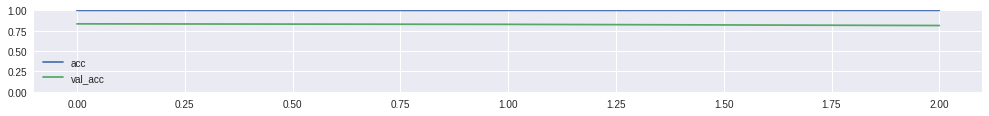

In [168]:
df = pd.DataFrame(data=histories)
for col in df.columns:
    df[col] =  df[col].apply(lambda x: x[-1])
plot=df[["acc","val_acc"]].plot()
plot.set_ylim([0,1])

means=df[["acc","val_acc"]].mean()
print("mean acc: {}, mean val_acc: {}".format(means["acc"],means["val_acc"]))

## Train RNN <a class="anchor" id="rnn"></a>

<a href='#table'>Back</a>
# OPTIMIZE<a class="anchor" id="opti"></a>

## Optimize on dropout<a class="anchor" id="opti_d"></a>

In [0]:
X_train, X_test, y_train, y_test = train_test_split(np.array(reviews), np.array(labels), test_size=0.25)

In [0]:
FOLDS=3
kfold = KFold(FOLDS, True, 1)

In [0]:
train_data = list(zip(X_train, y_train))

In [0]:
from pdb import set_trace

def getMeansFromResultsHistory(histories):
  df = pd.DataFrame(data=histories)
  for col in df.columns:
      df[col] =  df[col].apply(lambda x: x[-1])
  means=df[["acc","val_acc"]].mean()
  return means

def trainModel(epochs_nb=5,customLayers=[]):
  EPOCHS=5
  SAMPLE_SIZE=len(X_train)
  TRAIN_TEST_RATIO=(1/FOLDS)
  TRAINING_SET_SIZE=int(SAMPLE_SIZE * (1 - TRAIN_TEST_RATIO))
  VALIDATION_SET_SIZE=int(SAMPLE_SIZE * TRAIN_TEST_RATIO)

  histories=[]
  bestResults=None
  for train_indices, test_indices in kfold.split(X_train,y=y_train):
      model = keras.Sequential(customLayers)
      model.compile(
       optimizer = "adam",
       loss = "binary_crossentropy",
       metrics = ["accuracy"]
      )
      model.summary()
      K_X_train = X_train[train_indices]
      K_y_train = y_train[train_indices]
      K_X_test = X_train[test_indices]
      K_y_test = y_train[test_indices]
      results=model.fit(
          K_X_train, K_y_train,
          epochs=epochs_nb,
          validation_data=(K_X_test, K_y_test),
          batch_size=BATCH_SIZE
      )
      histories.append(results.history)
      bestResults=getBestResultsFrom(bestResults,results)
  
  means=getMeansFromResultsHistory(histories)
  print(means) 
  return bestResults,means

In [0]:
dropout_means=[]

### No dropout


In [182]:
rate=0.0
EPOCHS=5
startTime=time.time()
def layersWithNoDropouts():
  print("No dropouts on any layers")
  return [
      layers.Dense(256, activation = "relu", input_shape=(VOCAB_SIZE, )),
      layers.Dense(128, activation = "relu"),
      layers.Dense(1, activation = "sigmoid")
  ]
  
results,means=trainModel(epochs_nb=EPOCHS, customLayers=layersWithNoDropouts())
dropout_means.append([means["acc"],means["val_acc"], rate,0])
endTime=time.time()
training_duration_in_secs=endTime - startTime
saveTrainingMetrics("Opti-NN-Optimise with K-folds - No dropouts")

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_150 (Dense)            (None, 256)               256256    
_________________________________________________________________
dense_151 (Dense)            (None, 128)               32896     
_________________________________________________________________
dense_152 (Dense)            (None, 1)                 129       
Total params: 289,281
Trainable params: 289,281
Non-trainable params: 0
_________________________________________________________________
Train on 6250 samples, validate on 3125 samples
Epoch 1/5
6250/6250 [==============================] - 3s 417us/sample - loss: 0.4852 - acc: 0.7643 - val_loss: 0.3803 - val_acc: 0.8362
Epoch 2/5
6250/6250 [==============================] - 1s 145us/sample - loss: 0.2803 - acc: 0.8832 - val_loss: 0.3845 - val_acc: 0.8291
Epoch 3/5
6250/6250 [==============================] - 1s 154us/sample - loss:

### Low dropout on 1 layer

In [183]:
rate=0.2
EPOCHS=5
startTime=time.time()

def layersWithLowDropoutOnOneLayer(rate):
  print("Dropout on one layer, rate="+str(rate))
  return [
      layers.Dense(256, activation = "relu", input_shape=(VOCAB_SIZE, )),
      layers.Dropout(rate),
      layers.Dense(128, activation = "relu"),
      layers.Dense(1, activation = "sigmoid")
  ]
  
results,means=trainModel(epochs_nb=EPOCHS, customLayers=layersWithLowDropoutOnOneLayer(rate))
dropout_means.append([means["acc"],means["val_acc"], rate,1])
endTime=time.time()
training_duration_in_secs=endTime - startTime
saveTrainingMetrics("Opti-NN-Optimise with K-folds - Low dropout on 1 layer")

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_153 (Dense)            (None, 256)               256256    
_________________________________________________________________
dropout_43 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_154 (Dense)            (None, 128)               32896     
_________________________________________________________________
dense_155 (Dense)            (None, 1)                 129       
Total params: 289,281
Trainable params: 289,281
Non-trainable params: 0
_________________________________________________________________
Train on 6250 samples, validate on 3125 samples
Epoch 1/5
6250/6250 [==============================] - 3s 438us/sample - loss: 0.4880 - acc: 0.7662 - val_loss: 0.3791 - val_acc: 0.8435
Epoch 2/5
6250/6250 [==============================] - 1s 154us/sample - loss: 0.30

### High dropout on 1 layer


In [188]:
rate=0.4
EPOCHS=5
startTime=time.time()
def layersWithHighDropoutOnOneLayer(rate):
  print("Dropout on one layer, rate="+str(rate))
  return [
      layers.Dense(256, activation = "relu", input_shape=(VOCAB_SIZE, )),
      layers.Dropout(rate),
      layers.Dense(128, activation = "relu"),
      layers.Dense(1, activation = "sigmoid")
  ]
  
results,means=trainModel(epochs_nb=EPOCHS, customLayers=layersWithHighDropoutOnOneLayer(rate))
dropout_means.append([means["acc"],means["val_acc"], rate,1])
endTime=time.time()
training_duration_in_secs=endTime - startTime
saveTrainingMetrics("Opti-NN-Optimise with K-folds - High dropout on 1 layer")

Dropout on one layer, rate=0.4
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_159 (Dense)            (None, 256)               256256    
_________________________________________________________________
dropout_45 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_160 (Dense)            (None, 128)               32896     
_________________________________________________________________
dense_161 (Dense)            (None, 1)                 129       
Total params: 289,281
Trainable params: 289,281
Non-trainable params: 0
_________________________________________________________________
Train on 6250 samples, validate on 3125 samples
Epoch 1/5
6250/6250 [==============================] - 3s 483us/sample - loss: 0.5085 - acc: 0.7510 - val_loss: 0.3861 - val_acc: 0.8378
Epoch 2/5
6250/6250 [==============================]

### Low dropout on 2 layers

In [190]:
rate=0.2
EPOCHS=5
startTime=time.time()
def layersWithLowDropoutOnTwoLayers(rate):
  print("Dropout on two layers, rate="+str(rate))
  return [
      layers.Dense(256, activation = "relu", input_shape=(VOCAB_SIZE, )),
      layers.Dropout(rate),
      layers.Dense(128, activation = "relu"),
      layers.Dropout(rate),
      layers.Dense(1, activation = "sigmoid")
  ]
  
results,means=trainModel(epochs_nb=EPOCHS, customLayers=layersWithLowDropoutOnTwoLayers(rate))
dropout_means.append([means["acc"],means["val_acc"], rate,1])
endTime=time.time()
training_duration_in_secs=endTime - startTime
saveTrainingMetrics("Opti-NN-Optimise with K-folds - Low dropout on 2 layers")

Dropout on two layers, rate=0.2
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_162 (Dense)            (None, 256)               256256    
_________________________________________________________________
dropout_46 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_163 (Dense)            (None, 128)               32896     
_________________________________________________________________
dropout_47 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_164 (Dense)            (None, 1)                 129       
Total params: 289,281
Trainable params: 289,281
Non-trainable params: 0
_________________________________________________________________
Train on 6250 samples, validate on 3125 samples
Epoch 1/5
6250/6250 [==============================] - 3

### High dropout on 2 layers


In [191]:
rate=0.4
EPOCHS=5
startTime=time.time()
def layersWithHighDropoutOnTwoLayers(rate):
  print("Dropout on two layers, rate="+str(rate))
  return [
      layers.Dense(256, activation = "relu", input_shape=(VOCAB_SIZE, )),
      layers.Dropout(rate),
      layers.Dense(128, activation = "relu"),
      layers.Dropout(rate),
      layers.Dense(1, activation = "sigmoid")
  ]
  
results,means=trainModel(epochs_nb=EPOCHS, customLayers=layersWithHighDropoutOnTwoLayers(rate))
dropout_means.append([means["acc"],means["val_acc"], rate,1])
endTime=time.time()
training_duration_in_secs=endTime - startTime
saveTrainingMetrics("Opti-NN-Optimise with K-folds - High dropout on 2 layers")

Dropout on two layers, rate=0.4
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_165 (Dense)            (None, 256)               256256    
_________________________________________________________________
dropout_48 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_166 (Dense)            (None, 128)               32896     
_________________________________________________________________
dropout_49 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_167 (Dense)            (None, 1)                 129       
Total params: 289,281
Trainable params: 289,281
Non-trainable params: 0
_________________________________________________________________
Train on 6250 samples, validate on 3125 samples
Epoch 1/5
6250/6250 [==============================] - 3

Plot results

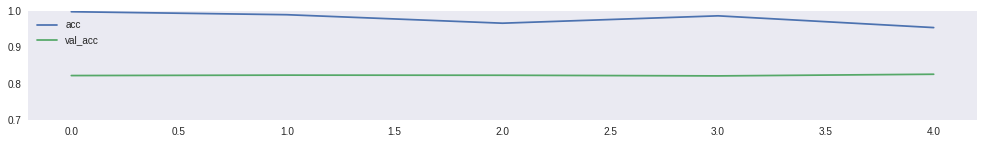

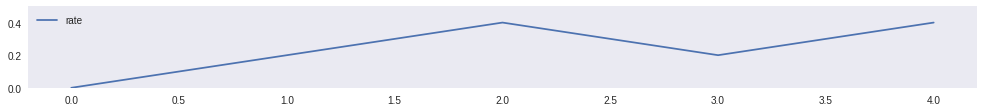

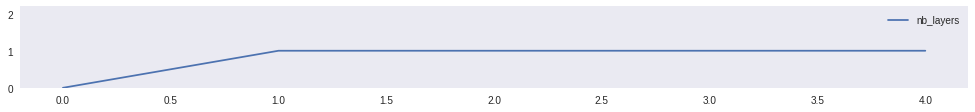

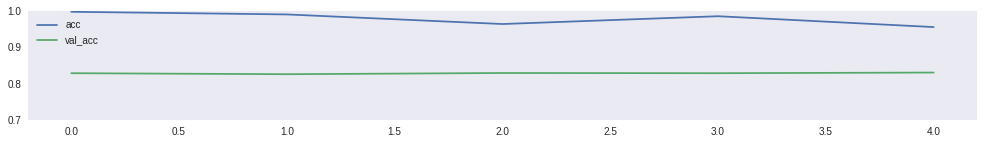

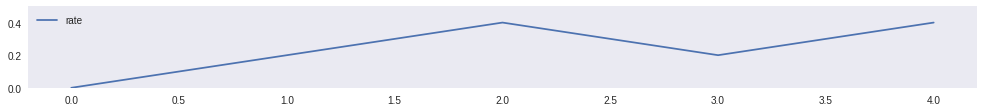

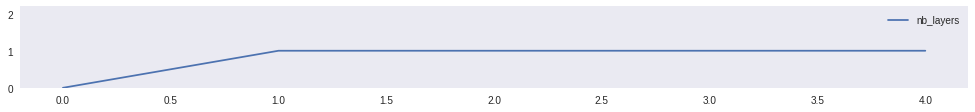

In [119]:
df = pd.DataFrame(data=dropout_means,columns=['acc','val_acc','rate','nb_layers'])
plt.rcParams["figure.figsize"] = [17,2]
plot=df[["acc","val_acc"]].plot()
plot.set_ylim([0.7,1])
plot.grid()

plt.rcParams["figure.figsize"] = [17,1.5]
plot=df[["rate"]].plot()
plot.set_ylim([0,0.5])
plot.grid()

plt.rcParams["figure.figsize"] = [17,1.5]
plot=df[["nb_layers"]].plot()
plot.set_ylim([0,2.2])
plot.grid()

In [120]:
dropout_means

[[0.9982399940490723, 0.8220799962679545, 0.0, 0],
 [0.9899733265240988, 0.823253353436788, 0.2, 1],
 [0.9665600260098776, 0.8229333360989889, 0.4, 1],
 [0.9868800044059753, 0.8211199839909872, 0.2, 1],
 [0.9544533491134644, 0.825706680615743, 0.4, 1]]

[[0.9980799953142802, 0.8285866777102152, 0.0, 0],
 [0.9907199939092001, 0.825813353061676, 0.2, 1],
 [0.9642666578292847, 0.8291200002034506, 0.4, 1],
 [0.985813319683075, 0.8285866777102152, 0.2, 1],
 [0.955893317858378, 0.8303999900817871, 0.4, 1]]

### Observation<a class="anchor" id="opti_d_o"></a>
we have similar results, but got a higher test accuracy with low dropout on all layers and also less overfit (training and test accuracies are closer)